In [ ]:
#Mount Google Drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

#!ls drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
import keras 
import numpy as np 
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import itertools
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout
from tensorflow.python.client import device_lib
from keras.models import model_from_json
from keras.models import load_model
from sklearn.metrics import confusion_matrix

In [ ]:
#Specify path to dataset
train_path = 'drive/ML/alpha/dataset/train'
test_path = 'drive/ML/alpha/dataset/test'

In [ ]:
#Import data into test, train and validation and pre-process by up-sampling
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['original', 'spliced'], batch_size=10)
test_batches =  ImageDataGenerator().flow_from_directory(test_path , target_size=(224,224), classes=['original', 'spliced'], batch_size=4)
#valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['original', 'spliced'], batch_size=4)


Found 1624 images belonging to 2 classes.
Found 221 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [ ]:
#ResNet 50 implementation
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import os
import warnings
import numpy as np
from tensorflow.keras.layers import Input, Activation, Conv2D, Dense, Dropout, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Add
from tensorflow.keras.models import Model
from keras import regularizers
height = 224
width = 224
channel = 3
model_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(height, width, channel))
conv1 = Conv2D(32, (3,3), activation = 'relu')(model_resnet.output)
pool1 = MaxPooling2D(2,2)(conv1)
bn1 = BatchNormalization(axis=channel)(pool1)
drop1 = Dropout(0.2)(bn1)
flatten1 = Flatten()(drop1)
fc2 = Dense(2, activation='softmax')(flatten1)
INI = Model(inputs=model_resnet.input, outputs=fc2)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
#VGG 16 Model Initlization
INI_MODEL = VGG16()
#INI_MODEL = VGG19()

#INI_MODEL.summary()
#INI_MODEL.type()
NEW_MODEL = Sequential()
for layer in INI_MODEL.layers:
   NEW_MODEL.add(layer)

NEW_MODEL.layers.pop()
#NEW_MODEL.summary()
for layer in NEW_MODEL.layers:
  layer.trainable = False
NEW_MODEL.add(Dense(2, activation='softmax'))
NEW_MODEL.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

553467904/553467096 [==============================] - 3s 0us/step


In [ ]:
#Saving weights and checkpoint
filepath="drive/ML/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
#Initialize GPU for training the model faster
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.1 GB  | Proc size: 4.6 GB
GPU RAM Free: 5957MB | Used: 9152MB | Util  61% | Total 15109MB


In [ ]:
#Define functions to plot confusion matrix and accuracy 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_training_curves(history):
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    #Plotting accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    #Plotting Loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
#Fitting the model 
NEW_MODEL.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = NEW_MODEL.fit(train_batches, steps_per_epoch=len(train_batches), validation_data=test_batches, validation_steps=len(test_batches), epochs=100, callbacks=callbacks_list, verbose=2)

In [ ]:
#Saving the model
#NEW_MODEL.load_weights("drive/ML/weights.hdf5")
model_json = NEW_MODEL.to_json()


with open("drive/ML/CNNImageSplicingDetectorModel.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
NEW_MODEL.save_weights("drive/ML/CNNImageSplicingDetectorModelWeights.h5")

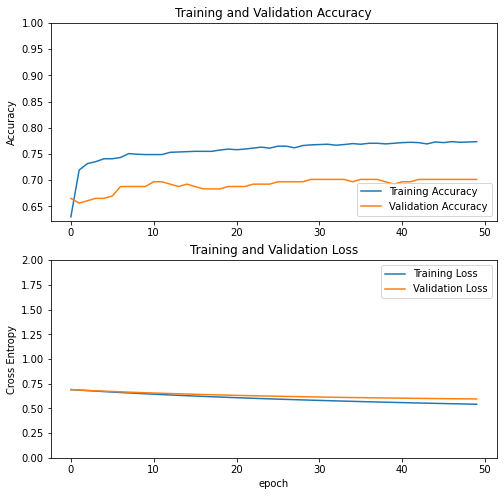

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
#Accuracy plot and Model summary
plot_training_curves(history)
NEW_MODEL.summary()

In [ ]:
#Model evaluation on Test data
NEW_MODEL.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print("The model loss and accruacy is")
NEW_MODEL.evaluate(x=test_batches)

The model loss and accruacy is
56/56 [==============================] - 118s 2s/step - loss: 0.5904 - accuracy: 0.6768


[0.5819605588912964, 0.7104072570800781]

In [ ]:
NEW_MODEL.evaluate(x=train_batches)

163/163 [==============================] - 618s 4s/step - loss: 0.5025 - accuracy: 0.7913


[0.5025094151496887, 0.7912561297416687]

1/1 [==============================] - 0s 76ms/step
[[0.6863638  0.3136362 ]
 [0.91405636 0.08594368]
 [0.8592204  0.14077961]
 [0.26860523 0.73139477]]
[1. 1. 0. 0.]
[1. 1. 1. 0.]
Confusion matrix, without normalization
[[1 1]
 [0 2]]


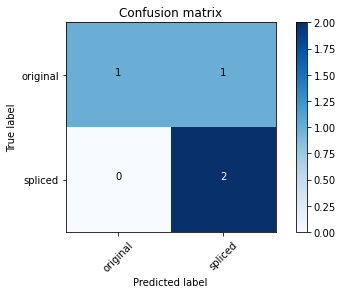

In [ ]:
test_imgs, test_labels = next(test_batches)
test_labels = test_labels[:,0]
test_labels
pred = NEW_MODEL.predict(test_batches, steps=1, verbose=1)
print(pred)
print (test_labels)
print (np.round(pred[:,0]))

CONF_MAT =  confusion_matrix(test_labels, np.round(pred[:,0]))
CONF_labels = ['original', 'spliced']
plot_confusion_matrix(CONF_MAT, CONF_labels, title='Confusion matrix')